<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Creating publication-ready figures with Pyleoclim and Matplotlib

## Authors

Deborah Khider

Author1 = {"name": "Deborah Khider", "affiliation": "Information Sciences Institute, University of Southern California", "email": "khider@usc.edu", "orcid": "0000-0001-7501-8430"}

## Preamble

### Goals

- Create a summary plot using Pyleoclim, which display the timeseries, power spectral density, and scalogram for a timeseries
- Use Matplotlib in combination with Pyleoclim to change the attributes of a plot

**Reading time:**

### Keywords

Visualization

### Pre-requisites

Loading data into a `Series` object; understandin basic time series manipulations (e.g., standardize, detrend, interpolation) with Pyleoclim; spectral and wavelet analysis in Pyleoclim. 

### Relevant Packages

Matplotlib

## Data Description

This tutorial makes use of the following datasets (stored in csv format): 

* Grinsted, A., Moore, J. C. & Jevrejeva, S. Application of the cross wavelet transform and wavelet coherence to geophysical time series. Nonlin. Processes Geophys. 11, 561–566 (2004). doi.org/10.5194/npg-11-561-2004 


## Demonstration

Let's import the necessary packages:

In [1]:
import pyleoclim as pyleo
import pandas as pd
import matplotlib.pyplot as plt

Let's import the data using pandas:

In [2]:
df = pd.read_csv('../data/wtc_test_data_nino_even.csv')
df

,t,air,nino
0,1871.000000,87.36090,-0.358250
1,1871.083333,-21.83460,-0.292458
2,1871.166667,-5.52632,-0.143583
3,1871.250000,75.73680,-0.149625
4,1871.333333,105.82000,-0.274250
...,...,...,...
1591,2003.583333,-206.03800,0.238497
1592,2003.666667,103.90200,0.411449
1593,2003.750000,218.24100,0.592756
1594,2003.833333,-154.66200,0.664131


In [3]:
ts = pyleo.Series(time =  df['t'], value = df['nino'],
                  time_name = 'Year', value_name = 'Niño 3',
                  time_unit = 'CE', value_unit = '$^\circ$C')   

Prior to analysis, let's standardize the time series:

In [4]:
ts_std = ts.standardize()

Next, let's check if the timeseries is evenly-spaced to apply the appropriate spectral and wavelet analysis functions:

In [5]:
ts_std.is_evenly_spaced()

True

Since the timeseries is evenly-spaced, let's use MTM and the continuous wavelet method from Torrence and Compo ([doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2](doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2)). 

In [6]:
PSD = ts_std.spectral(method='mtm') #spectral analysis
PSD_signif = PSD.signif_test() #run AR(1) significance test

scal = ts_std.wavelet(method='cwt') #wavelet analysis
scal_signif=scal.signif_test() #run AR(1) significance test

Performing spectral analysis on individual series: 100%|█| 200/200 [00:12<00:00,
Performing wavelet analysis on individual series: 100%|█| 200/200 [00:04<00:00, 


To create a plot that summarizes the results of our analysis, we can use the [`summary_plot`](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.series.Series.summary_plot) function. Let's use the default parameters to first see what the plot looks like. Note that the function is called from the original object (prior to standardization so the timeseries plot refers to the original timeseries):

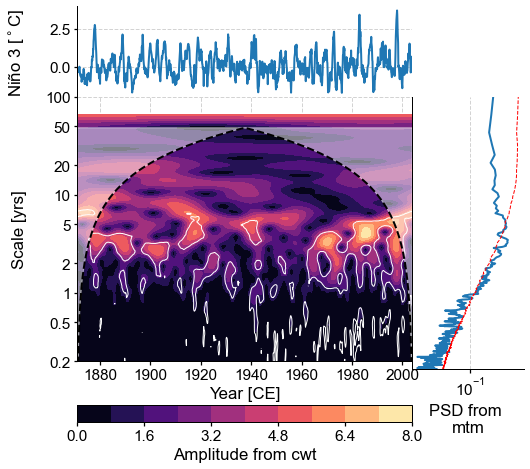

In [7]:
fig,ax =  ts.summary_plot(psd=PSD_signif,scalogram=scal_signif)

Here are a summary of the changes we are going to make to the plot:

* Remove the time label. This is obvisouly Year CE and is not needed
* Change the label for the PSD panel. By default, Pyleoclim will include the method by which the PSD was obtained. This is very useful information as various options are explored and compared but the method could go into the caption of the figure at publication time.
* Similarly, 'from cwt' can be removed from the label of the colorbar
* Change the limit of the scale axis from [0,50]

Some of the changes can be directly made through the function call. Let's go over the relevant parameters for the [function](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.series.Series.summary_plot):
* `time_label` can be used to remove the Year CE label. In this case, we just can set it to a blank string
* `psd_label` can be used to remove the PSD label. 
* The label for the color bar is trickier since it's not directly accessible. However, Matplotlib has a nifty function to help retrieve all the `ax` for the figure (`figure.axes`)
* The y limits for the scalogram are not directly exposed through `summary_plot`. However, the function allows to pass relevant arguments to the underlying [`Scalogram.plot` function](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.scalograms.Scalogram.plot) using `ylim`. 

Our first order of business is to figure out which axis corresponds to the colorbar:

In [9]:
ax_list = fig.axes
ax_list

[<AxesSubplot:xlabel='Year [CE]', ylabel='Niño 3 [$^\\circ$C]'>,
 <AxesSubplot:ylabel='Frequency [1/yrs]'>,
 <AxesSubplot:label='<colorbar>', xlabel='Amplitude from cwt'>,
 <AxesSubplot:xlabel='PSD'>]

It's the third item on the list (index=2).

Text(0.5, 0, 'Amplitude')

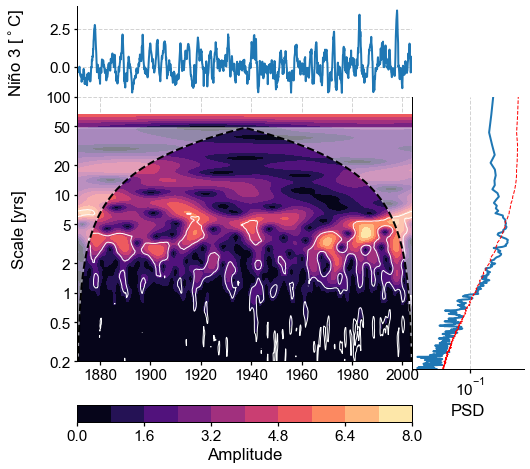

In [11]:
fig, ax = ts.summary_plot(PSD_signif, scal_signif,
                          psd_label='PSD',
                          time_label='',
                          wavelet_plot_kwargs={'ylim':[0.2,50]})
ax_list = fig.axes
ax_list[2].set_xlabel('Amplitude')

This is better but:
* The ylim didn't get set properly on the scalogram. This happens as order of operations sometimes matters in Python. Let's try to set it after making the main figure through the second ax in `ax_list`. 
* The colorbar is now sitting far from the plot. Matplotlib has a `pad` argument to its [`colorbar` function](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.colorbar.html) that we can pass through `cbar_style` in the `Scalogram.plot` function. 

Let's try again:

(0.2, 50.0)

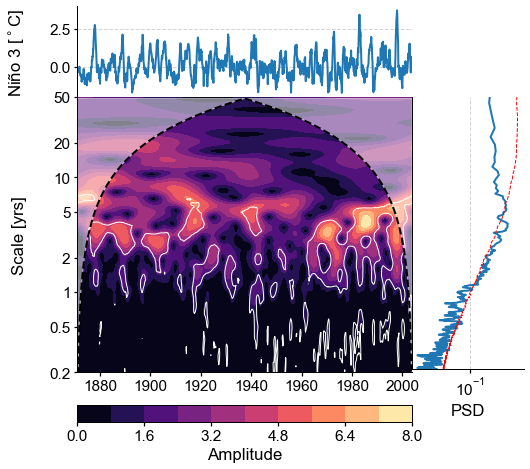

In [12]:
fig, ax = ts.summary_plot(PSD_signif, scal_signif,
                          psd_label='PSD',
                          time_label='',
                          wavelet_plot_kwargs={'cbar_style':{'pad':0.09}})
ax_list = fig.axes
ax_list[2].set_xlabel('Amplitude')
ax_list[1].set_ylim([0.2,50])

This is looking much better already! Note that setting the `pad` value takes a little bit of trial and error. One last tweak is to make the y-axis for the timeseries symmetrical around 0 by passin a ylim. Let's do this through the `value_lim` paramater:

(0.2, 50.0)

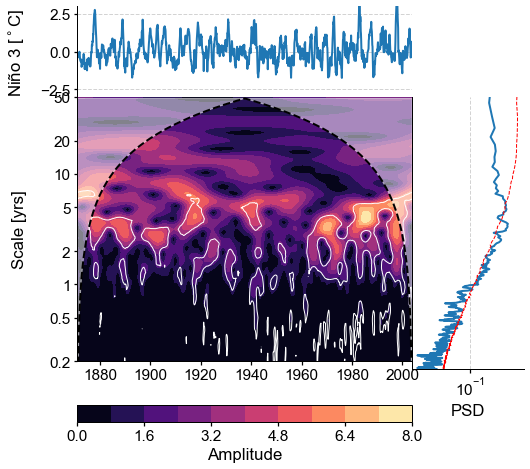

In [18]:
fig, ax = ts.summary_plot(PSD_signif, scal_signif,
                          psd_label='PSD',
                          time_label='',
                          value_lim=[-3,3],
                          wavelet_plot_kwargs={'ylim':[0.2,50]})
ax_list = fig.axes
ax_list[2].set_xlabel('Amplitude')
ax_list[1].set_ylim([0.2,50])

Better! but now the tickmarks are running into each other. Let's remove the '50'. The first step is to retrieve the list of ticks:

In [20]:
locs = ax_list[1].get_yticks()
locs

array([  0.2,   0.5,   1. ,   2. ,   5. ,  10. ,  20. ,  50. , 100. ])

Let's only keep to 20:

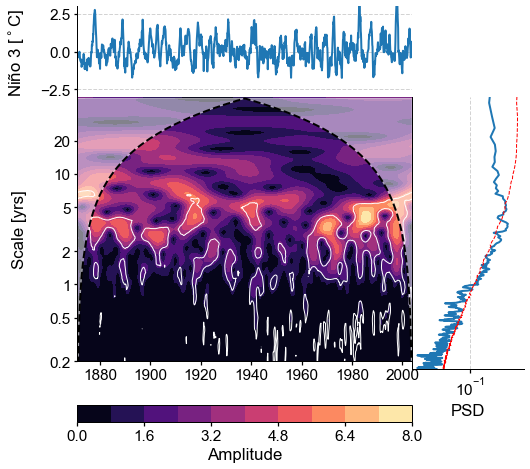

In [22]:
fig, ax = ts.summary_plot(PSD_signif, scal_signif,
                          psd_label='PSD',
                          time_label='',
                          value_lim=[-3,3],
                          wavelet_plot_kwargs={'ylim':[0.2,50]})
ax_list = fig.axes
ax_list[2].set_xlabel('Amplitude')
ax_list[1].set_ylim([0.2,50])
yticks = ax_list[1].get_yticks()[0:-2] # gets rid of 50,100
locs = ax_list[1].set_yticks(yticks) # get the location and labels of the existing ticks

And our plot is ready for publication!